In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.python.data import AUTOTUNE
# from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, Activation, Rescaling
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential as SequentialModel
# import keras_tuner as kt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
# import itertools

import os
# import time

from pathlib import Path

tf.random.set_seed(5263)
tf.__version__

'2.15.0'

This cell is equivalent to importing `dataset_builder.py`

In [ ]:
import pandas as pd

from os import walk
from os.path import isfile, join

from pathlib import Path

# TODO: Add absolute option to choose whether paths become absolute when compiled,
#  then use that to make a function that can store the compiled labels as a singular CSV

class NoLabelFilesFoundError(Exception):
    def __init__(self, *args):
        super().__init__(*args)

def compile_label_files_in_directory(directory: Path, label_file_name: str) -> list[Path]:
    """
    Looks for all files with the name `label_file_name`, and returns all absolute paths of those files.

    :param directory: The root directory to check for label files within
    :param label_file_name: The name of the label file to look for (assumes all requested label files have this name)

    :return: A list of all `pathlib.Path` of the found label files. If no label files are found, an empty list will be returned.
    """

    if type(directory) == str:
        directory = Path(directory)
    # Include subclasses like `WindowsPath`, `PosixPath` etc
    elif not isinstance(directory, Path):
        raise ValueError("`directory` must be a `Path` to the requested dataset.")

    label_file_paths = []

    if not directory.is_dir():
        raise ValueError(f"The `directory` '{directory}' is not valid. Please check your arguments.")

    else:
        for cur_path, directories, files in walk(directory):
            for file in files:
                if file == label_file_name:
                    label_file_paths.append(Path(join(cur_path, file)))
                    break

    if not label_file_paths:
        raise NoLabelFilesFoundError("No label files were found in this directory.")

    return label_file_paths


def compile_dataset_labels(label_file_paths: list[Path]) -> pd.DataFrame:
    """
    Checks all label files within `label_file_paths`, loads each file one at a time, and concatenates all rows
    into a single `DataFrame`. All paths are made absolute to ensure consistency with usage from other libraries.

    :param label_file_paths: The paths of all label files to concatenate together. All files must be `CSV` files

    :return: A `DataFrame` with all label file rows concatenated together, with paths resolved to be absolute.
    """

    # Anything that can be iterated through in the same way as a list will work, so tuples and sets are fine
    if type(label_file_paths) in (list, tuple, set):
        if not all(isinstance(label_file, Path) for label_file in label_file_paths):
            raise ValueError("All paths within `label_file_paths` must be a `pathlib.Path`.")
    else:
        raise ValueError("A list of paths containing all label files is required.")

    dataframes = []

    for label_file in label_file_paths:
        try:
            df = pd.read_csv(label_file)
        except pd.errors.ParserError:
            raise ValueError("Invalid label file given - Ensure all files are CSV files.")

        # Get the folder the CSV resides in - it should be in the same folder as the data,
        # so we can use that to get their paths too.
        data_folder = label_file.parent
        for row_num, row in df.iterrows():
            sample_path = (data_folder / row[0]).resolve()

            if isfile(sample_path):
                df.loc[row_num, "file_name"] = str(sample_path)
            else:
                raise ValueError(f"'{row[0]}' does not resolve to a real file. Check that all files are present. "
                                 f"(File path checked: {sample_path})")

        dataframes.append(df)

    return pd.concat(dataframes, axis=0)


def dataset_labels_to_dataframe(dataset_directory: Path, label_file_name: str) -> pd.DataFrame:
    """
    Convenience function that runs `compile_label_files_in_directory` and `compile_dataset_labels`.

    :param dataset_directory: The directory of the dataset to collect and compile label files from.
    :param label_file_name: The name of the label file (assumes that the name of the file will be the same for each dataset within the directory)

    :return: A `DataFrame` that holds all entries from each label file found, with all file paths resolved to be absolute.
    """
    return compile_dataset_labels(compile_label_files_in_directory(dataset_directory, label_file_name))


In [ ]:
dataset_path = Path("") / "drive" / "MyDrive" / "WA.M.AI datasets" / "FiNALE+AstroDX 1"

df = dataset_labels_to_dataframe(dataset_path, "8_zone_presence_labels.csv")
# Immediately shuffle the dataframe to ensure that the resulting validation dataset is good quality
df = df.sample(frac=1)
# Dataset size
len(df.index)

10296

In [ ]:
file_names = df["file_name"].values

file_names[0]

'/content/drive/MyDrive/WA.M.AI datasets/FiNALE+AstroDX 1/mkdr-basic-15-played/mkdr-basic-15-played-0000001239.png'

In [ ]:
labels = df.drop("file_name", axis=1)

labels.head()

,b1,b2,b3,b4,b5,b6,b7,b8
1211,False,False,False,False,False,True,False,False
577,True,False,True,False,False,False,False,True
1067,True,False,False,False,False,False,False,False
1713,False,False,False,True,True,False,False,False
824,True,True,False,False,False,False,False,False


In [ ]:
# Initially loading dataset with paths - will be replaced with image source retroactively
dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
# Shuffle whole dataset before loading images
dataset_size = dataset.cardinality()

# Relatively arbitrary split
eval_dataset_size = int(dataset_size/12)

# Shuffle the dataset to prepare it for splitting (so the eval set isn't just the end of a single chart
# and instead accurately gives unpredictable samples that cover a wider range of the model's capabilities)
## Not necessary if it is immediately done while still a dataframe
# dataset.shuffle(buffer_size=dataset.cardinality(), seed=3126)
# Split the entire dataset into a training and evaluation dataset
eval_dataset = dataset.take(eval_dataset_size)
dataset = dataset.skip(eval_dataset_size).take(dataset_size)

# Ensure that specifically the training dataset is given in different orders on each epoch
dataset.shuffle(buffer_size=dataset.cardinality(), reshuffle_each_iteration=True)
dataset

<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(8,), dtype=tf.bool, name=None))>

In [ ]:
cardinalities = [dataset.cardinality(), eval_dataset.cardinality()]
cardinalities

[<tf.Tensor: shape=(), dtype=int64, numpy=9438>,
 <tf.Tensor: shape=(), dtype=int64, numpy=858>]

In [ ]:
# Normalise image values to 0-1 from 0-255, and ensure all images are 400x400
IMG_SIZE = (400, 400, 3)
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  layers.Rescaling(1./255)
])

def read_image(image_path, labels):
    # Read data from file path and resize to 400x400
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = resize_and_rescale(image)
    # `decode_png` does not state the size of the image, so we force it here`
    # image.set_shape([400, 400, 3])
    # In a normal dataset, the first dimension states how many samples are in the set.
    # Since teach tensor set here represents 1 sample, we insert a new dimension (which will have length 1)
    # to state that there is 1 sample
    image = tf.expand_dims(image, 0)
    labels = [labels]

    return image, labels

dataset = dataset.map(read_image)
eval_dataset = eval_dataset.map(read_image).prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.map(read_image)
# train_ds
dataset

<_MapDataset element_spec=(TensorSpec(shape=(1, 400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 8), dtype=tf.bool, name=None))>

In [ ]:
# https://www.tensorflow.org/tutorials/images/data_augmentation
def augment(image_label, seed):
  image, label = image_label
  # Make a new seed.
  new_seed = tf.random.split(seed, num=1)[0, :]
  # Random brightness. - NOTE: This has been adjusted as 0.5 delta creates
  # such a difference that some notes may be indiscernable,
  # and cause a garbage-in-garbage-out-loop
  # 0.25 in finale 1 training
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.2, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

rng = tf.random.Generator.from_seed(9172, alg='philox')

# Create a wrapper function for updating seeds.
# @tf.function
def augment_with_seed(image, label):
  seed = rng.make_seeds(2)[0]
  image, label = augment((image, label), seed)
  return image, label
## raises `OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed.`
dataset = dataset.map(augment_with_seed, num_parallel_calls=AUTOTUNE).prefetch(tf.data.AUTOTUNE)

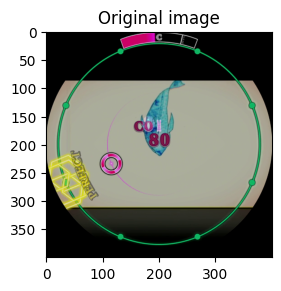

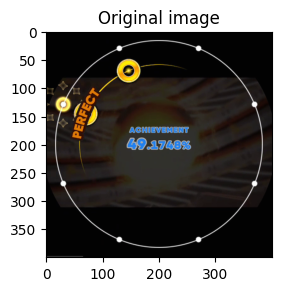

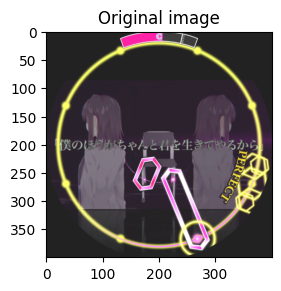

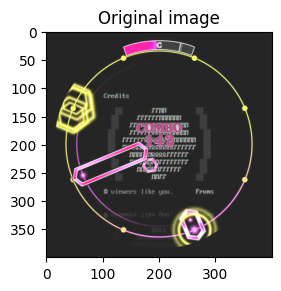

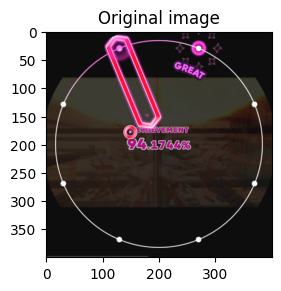

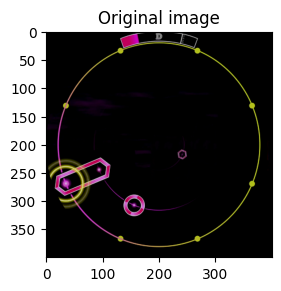

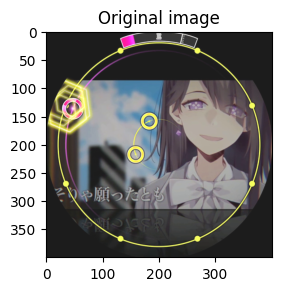

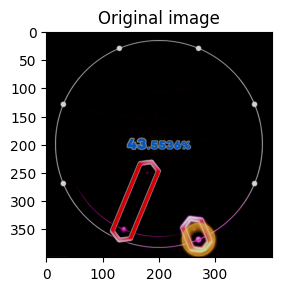

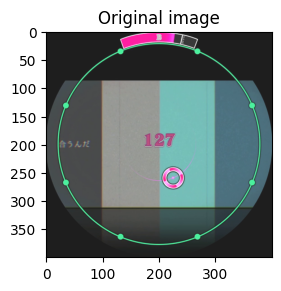

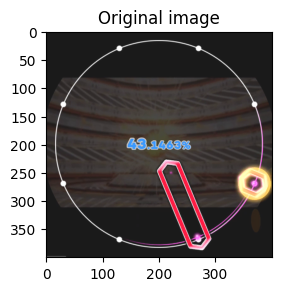

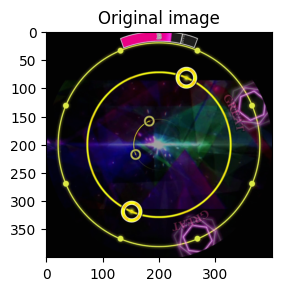

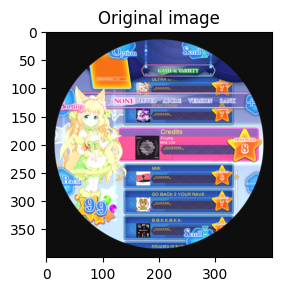

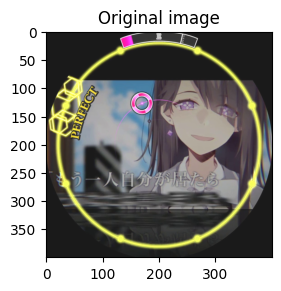

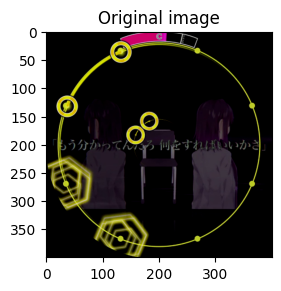

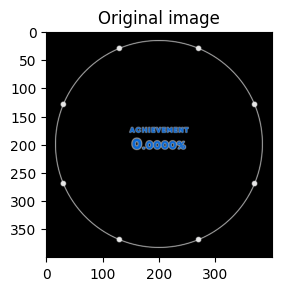

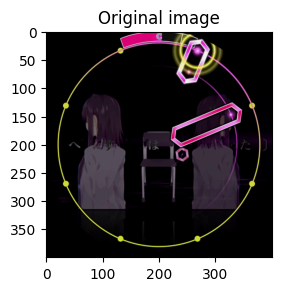

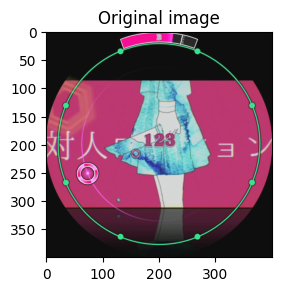

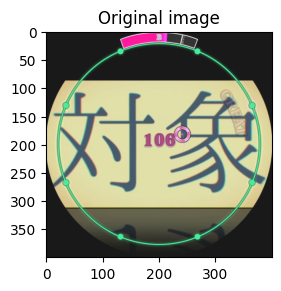

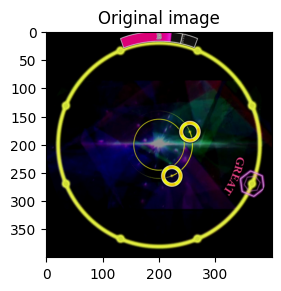

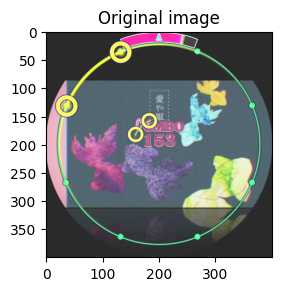

In [ ]:
# Visualise the first 5 items in the dataset to ensure that augmentation works as expected
def visualize(original):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

items = dataset.take(20)

for i in items.as_numpy_iterator():
    visualize(i[0][0])

Model builder to construct different models for testing:

In [ ]:
# Model structure based on the best model fount in the first tuning run - an ideal amount of models have not been tested, but it's a much more well informed model than the original.

def build_wamai_model():
  wamai_model = keras.Sequential()

  # Convolutional layers for image detail processing
  wamai_model.add(layers.Conv2D(filters = 40,
                  kernel_size = 2,
                  strides = 1,
                  input_shape = IMG_SIZE))
  wamai_model.add(layers.Activation('relu'))
  wamai_model.add(layers.BatchNormalization())

  wamai_model.add(layers.Conv2D(filters = 48,
                  kernel_size = 4,
                  strides = 3))
  wamai_model.add(layers.Activation('relu'))
  wamai_model.add(layers.BatchNormalization())

  wamai_model.add(layers.Conv2D(filters = 192,
                  kernel_size = 3,
                  strides = 2))
  wamai_model.add(layers.Activation('relu'))
  wamai_model.add(layers.BatchNormalization())

  wamai_model.add(layers.MaxPool2D(pool_size = 2))
  wamai_model.add(layers.Conv2D(filters = 16,
                  kernel_size = 3))
  wamai_model.add(layers.Activation('relu'))
  wamai_model.add(layers.BatchNormalization())

  # Pooling for performance
  wamai_model.add(layers.MaxPool2D(pool_size = 2))
  wamai_model.add(layers.Flatten())

  # Dense layers to process flattened outputs to produce final labels
  wamai_model.add(layers.Dense(units = 704))
  wamai_model.add(layers.Activation('relu'))

  wamai_model.add(layers.Dense(units = 1920))
  wamai_model.add(layers.Activation('relu'))

  wamai_model.add(layers.Dense(units = 1472))
  wamai_model.add(layers.Activation('relu'))

  wamai_model.add(layers.Dense(units = 8))
  wamai_model.add(layers.Activation('sigmoid'))

  wamai_model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='binary_crossentropy',
                    metrics=["accuracy"])

  return wamai_model

wamai_model = build_wamai_model()

In [ ]:
# tuner = kt.Hyperband(
#     hypermodel=build_wamai_model,
#     objective="val_accuracy",
#     hyperband_iterations=2
# )

model_folder = Path("") / "drive" / "MyDrive" / "WA.M.AI models" / "FiNALE+Astro 1"
# model_folder_string = str(model_folder)
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

checkpoint_filepath = str(model_folder / "WA.M.AI-p-finale-epoch{epoch:02d}-l{val_loss:.2f}-acc{val_accuracy:.4f}.keras")

# Save a new model every time it improves
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath=checkpoint_filepath,
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5)

wamai_model.fit(dataset, validation_data=eval_dataset)

Trial 15 Complete [00h 07m 49s]
val_accuracy: 0.42191141843795776

Best val_accuracy So Far: 0.43822842836380005
Total elapsed time: 01h 47m 19s

Search: Running Trial #16

Value             |Best Value So Far |Hyperparameter
24                |64                |conv_1_filters
4                 |2                 |conv_1_kernel_size
3                 |1                 |conv_1_strides
128               |48                |conv_2_filters
2                 |3                 |conv_2_kernel_size
1                 |2                 |conv_2_strides
144               |128               |conv_3_filters
2                 |3                 |conv_3_kernel_size
1                 |2                 |conv_3_strides
2                 |2                 |pool_1_size
48                |96                |conv_4_filters
4                 |4                 |conv_4_kernel_size
4                 |2                 |pool_2_size
768               |704               |dense_1_units
1536              |384 